<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Цель:" data-toc-modified-id="Цель:-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Цель:</a></span></li><li><span><a href="#Технологический-процесс" data-toc-modified-id="Технологический-процесс-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Технологический процесс</a></span></li><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Описание данных</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Проверка-расчёта-эффективности-обогащения" data-toc-modified-id="Проверка-расчёта-эффективности-обогащения-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Проверка расчёта эффективности обогащения</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Модель" data-toc-modified-id="Модель-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Модель</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Восстановление золота из руды
Сборный проект 2
Выполнил Максим Ларин

## Цель:

Подготовить прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной
работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды используя данные с
параметрами добычи и очистки.

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

    ## Технологический процесс

<img src="https://pictures.s3.yandex.net/resources/viruchka_1576238830.jpg" width="600" height="300">

<br><a name="d">Расчёт эффективности</a><br>
<img src='https://pictures.s3.yandex.net/resources/Recovery_1576238822.jpg' width="600" height="150">

C — доля золота в концентрате после флотации/очистки;<br>
F — доля золота в сырье/концентрате до флотации/очистки;<br>
T — доля золота в отвальных хвостах после флотации/очистки.<br>

<br>Метрика качества<br>
<img src='https://pictures.s3.yandex.net/resources/smape_1576239058.jpg' width="600" height="200">

sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»)<br>
Одинаково учитывает масштаб и целевого признака, и предсказания.<br>
<br>
<img src='https://pictures.s3.yandex.net/resources/_smape_1576239054.jpg' width="600" height="200">

Нужно спрогнозировать сразу две величины:<br>
эффективность обогащения чернового концентрата rougher.output.recovery;<br>
эффективность обогащения финального концентрата final.output.recovery.<br>


## Описание данных
***Технологический процесс***

- Rougher feed — исходное сырье
- Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
    > Xanthate **— ксантогенат (промотер, или активатор флотации);<br>
    >  Sulphate — сульфат (на данном производстве сульфид натрия);<br>
    > Depressant — депрессант (силикат натрия).
- Rougher process (англ. «грубый процесс») — флотация
- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота

***Параметры этапов***
- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи

***Наименование признаков***
Наименование признаков должно быть такое:<br>
 > `[этап].[тип_параметра].[название_параметра]`<br>
 > ``Пример: rougher.input.feed_ag``<br>
 > ```Возможные значения для блока [этап]:```<br>
- rougher — флотация
- primary_cleaner — первичная очистка
- secondary_cleaner — вторичная очистка
- final — финальные характеристики
- Возможные значения для блока [тип_параметра]:
- input — параметры сырья
- output — параметры продукта
- state — параметры, характеризующие текущее состояние этапа
- calculation — расчётные характеристики

## Подготовка данных

In [449]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
from scipy import stats as st
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
import plotly.express as ex
from plotly.subplots import make_subplots

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [450]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.dummy import DummyClassifier

In [451]:
try:
    data_train = pd.read_csv('gold_recovery_train_new.csv', index_col='date')
    data_test = pd.read_csv('gold_recovery_test_new.csv', index_col='date')
    data_full = pd.read_csv('gold_recovery_full_new.csv', index_col='date')
except:
    data_train = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_train_new.csv', index_col='date')
    data_test = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_test_new.csv', index_col='date')
    data_full = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_full_new.csv', index_col='date')


In [452]:
%lsmagic

Available line magics:
%alias  %alias_magic  %autoawait  %autocall  %automagic  %autosave  %bookmark  %cat  %cd  %clear  %colors  %conda  %config  %connect_info  %cp  %debug  %dhist  %dirs  %doctest_mode  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %lf  %lk  %ll  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %lx  %macro  %magic  %man  %matplotlib  %mkdir  %more  %mv  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %pip  %popd  %pprint  %precision  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %rep  %rerun  %reset  %reset_selective  %rm  %rmdir  %run  %save  %sc  %set_env  %store  %sx  %system  %tb  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%capture  %%debug  %%file  %%html  %%javascript  %%js  %%latex  %%markdown  %%perl  %%prun  %%pypy  %%

In [453]:
color_pal = sns.color_palette()
RANDOM_STATE = 6266
CONCENTRATE_METRICS = [
    'rougher.input.feed', \
    'rougher.output.concentrate', \
    'primary_cleaner.output.concentrate', \
    'final.output.concentrate', ]

TAIL_METRICS = ['rougher.output.', \
    'primary_cleaner.output.', \
    'secondary_cleaner.output.', \
    'final.output.']

TARGET = ['rougher.output.recovery', 'final.output.recovery']
#список столбцов
TEST_COLUMNS = data_test.columns.tolist() + TARGET

In [454]:
# перевели индекс в datetime64 формат
data_full.index = pd.to_datetime(data_full.index)
data_train.index = pd.to_datetime(data_train.index)
data_test.index = pd.to_datetime(data_test.index)

In [455]:
# смотрим на пропуски в данных считаем количество и процентное соотношение
def isna_count_procent(data, name):
    isna_columns = data.isna().sum() > 0
    isna_columns = pd.DataFrame([data.isna().sum()[isna_columns]/data.shape[0], data.isna().sum()[isna_columns]]).T
    isna_columns = isna_columns.rename(columns={0: 'procent', 1: 'count'})
    isna_columns['count'] = isna_columns['count'].map('{:,.2f}'.format)
    isna_columns['procent'] = isna_columns['procent'].map('{:,.2%}'.format)
    isna_columns = isna_columns.sort_values('procent', ascending=False)
    # блок показывае всё о данных
    display(data.head(10))
    print('#'*55)
    print()
    display(data.describe())
    print('#'*55)
    print()
    data.info()
    print('#'*55)
    isna = data.isna().sum().sum()
    isna_procent = isna/data.shape[0]
    print()
    print(f'Всего пропусков в {name} {isna} шт. в {len(isna_columns)} столбцах')
    print(f'В процентном отношении {isna_procent:.2%} шт. от {data.shape[0]} длинны')

    return isna_columns, pd.set_option('display.max_rows', None)

In [456]:
print('Знакомимся с данными data_full')
isna_count_procent(data_full, 'data_full')

Знакомимся с данными data_full


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
2016-01-15 05:00:00,6.482968,10.049416,5.480257,41.633678,69.465816,10.182708,0.664118,16.999638,1.918586,115.581252,...,13.938497,-500.970168,11.883350,-500.395298,10.054147,-496.374715,7.965083,-499.364752,14.017067,-599.707915
2016-01-15 06:00:00,6.533849,10.058141,4.569100,41.995316,69.300835,10.304598,0.807342,16.723575,2.058913,117.322323,...,14.046819,-500.971133,12.091543,-500.501426,10.003247,-497.083180,8.010890,-500.002423,14.029649,-600.905470
2016-01-15 07:00:00,6.130823,9.935481,4.389813,42.452727,70.230976,10.443288,0.949346,16.689959,2.143437,124.592960,...,13.974691,-501.819696,12.101324,-500.583446,9.873169,-499.171928,7.993381,-499.794518,13.984498,-600.411070
2016-01-15 08:00:00,5.834140,10.071156,4.876389,43.404078,69.688595,10.420140,1.065453,17.201948,2.209881,131.781026,...,13.964030,-504.252450,12.060738,-501.174549,10.033838,-501.178133,7.881604,-499.729434,13.967135,-599.061188


#######################################################



,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,19438.000000,19438.000000,19228.000000,19439.000000,19439.000000,19438.000000,19338.000000,19433.000000,19439.000000,19415.000000,...,19433.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19437.000000,19438.000000
mean,5.168470,9.978895,9.501224,44.076513,67.050208,9.688589,2.705795,10.583728,3.042467,144.624774,...,18.987674,-485.894516,15.010366,-461.078636,15.694452,-488.684065,12.198224,-487.149827,18.959024,-505.436305
std,1.372348,1.669240,2.787537,5.129784,10.125840,2.328642,0.949077,2.868782,0.922808,44.464071,...,5.411058,47.758570,4.890228,67.405524,5.510974,34.533396,5.333024,38.347312,5.550498,37.689057
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.798523,0.000000,-800.836914,-0.372054,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,4.251240,9.137262,7.722820,43.402215,63.299712,8.062878,2.040119,8.938947,2.461138,114.107029,...,14.975734,-500.704892,11.940294,-500.187742,10.988606,-500.458467,8.971105,-500.129462,14.983037,-500.728067
50%,5.066094,10.102433,9.218961,45.011244,68.172738,9.743623,2.748730,10.622456,2.984909,143.232103,...,18.017481,-499.837793,14.971014,-499.459786,15.000036,-499.802605,11.019433,-499.935317,19.960541,-500.048400
75%,5.895527,11.035769,10.947813,46.275313,72.686642,11.134294,3.333216,12.104271,3.571351,175.075656,...,23.012470,-498.249730,19.034162,-400.118106,18.026190,-498.384187,14.019088,-499.436708,24.003170,-499.495378
max,16.001945,17.031899,19.615720,52.756638,100.000000,19.552149,5.804178,22.317730,8.245022,265.983123,...,30.115735,-245.239184,31.269706,-6.506986,43.709931,-244.483566,27.926001,-137.740004,32.188906,-104.427459


#######################################################

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19439 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         19438 non-null  float64
 1   final.output.concentrate_pb                         19438 non-null  float64
 2   final.output.concentrate_sol                        19228 non-null  float64
 3   final.output.concentrate_au                         19439 non-null  float64
 4   final.output.recovery                               19439 non-null  float64
 5   final.output.tail_ag                                19438 non-null  float64
 6   final.output.tail_pb                                19338 non-null  float64
 7   final.output.tail_sol                               19433 non-nul

(                                                   procent     count
 secondary_cleaner.output.tail_sol                    8.99%  1,748.00
 rougher.input.floatbank11_xanthate                   2.33%    453.00
 rougher.state.floatbank10_e_air                      2.24%    436.00
 primary_cleaner.output.concentrate_sol               1.90%    370.00
 secondary_cleaner.state.floatbank2_a_air             1.13%    220.00
 final.output.concentrate_sol                         1.09%    211.00
 rougher.input.feed_size                              0.75%    145.00
 primary_cleaner.output.concentrate_pb                0.60%    116.00
 primary_cleaner.input.xanthate                       0.54%    104.00
 final.output.tail_pb                                 0.52%    101.00
 rougher.input.feed_sol                               0.51%     99.00
 rougher.input.feed_pb                                0.51%    100.00
 primary_cleaner.output.tail_sol                      0.32%     62.00
 rougher.input.float

In [457]:
print('Знакомимся с данными data_train')
isna_count_procent(data_train, 'data_train')

Знакомимся с данными data_train


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
2016-01-15 05:00:00,6.482968,10.049416,5.480257,41.633678,69.465816,10.182708,0.664118,16.999638,1.918586,115.581252,...,13.938497,-500.970168,11.883350,-500.395298,10.054147,-496.374715,7.965083,-499.364752,14.017067,-599.707915
2016-01-15 06:00:00,6.533849,10.058141,4.569100,41.995316,69.300835,10.304598,0.807342,16.723575,2.058913,117.322323,...,14.046819,-500.971133,12.091543,-500.501426,10.003247,-497.083180,8.010890,-500.002423,14.029649,-600.905470
2016-01-15 07:00:00,6.130823,9.935481,4.389813,42.452727,70.230976,10.443288,0.949346,16.689959,2.143437,124.592960,...,13.974691,-501.819696,12.101324,-500.583446,9.873169,-499.171928,7.993381,-499.794518,13.984498,-600.411070
2016-01-15 08:00:00,5.834140,10.071156,4.876389,43.404078,69.688595,10.420140,1.065453,17.201948,2.209881,131.781026,...,13.964030,-504.252450,12.060738,-501.174549,10.033838,-501.178133,7.881604,-499.729434,13.967135,-599.061188


#######################################################



,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,14148.000000,14148.000000,13938.000000,14149.000000,14149.000000,14149.000000,14049.000000,14144.000000,14149.000000,14129.000000,...,14143.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14147.000000,14148.000000
mean,5.142034,10.132960,9.202849,44.003792,66.518832,9.607035,2.597298,10.512122,2.918421,133.320659,...,19.985454,-478.696836,15.487065,-460.229416,16.775136,-483.956022,13.064590,-483.966564,19.577539,-506.798480
std,1.369586,1.654930,2.790516,4.905261,10.295402,2.319069,0.971843,3.003617,0.903712,39.431659,...,5.657723,50.736021,5.255655,58.843586,5.831906,37.892788,5.765617,39.207913,5.764417,37.079249
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.709069,0.000000,-799.889113,-0.372054,-797.142475,0.646208,-800.006180,0.195324,-809.398668
25%,4.211620,9.297355,7.484645,43.276111,62.545817,7.997429,1.905973,8.811324,2.368607,107.006651,...,14.990775,-500.628656,11.894558,-500.149000,11.083980,-500.363177,8.994405,-500.105994,14.989304,-500.745104
50%,4.994652,10.297144,8.845462,44.872436,67.432775,9.480270,2.592022,10.514621,2.851025,133.018328,...,20.001789,-499.681450,14.975536,-499.388738,17.932223,-499.702452,11.997547,-499.914556,19.984175,-500.061431
75%,5.859540,11.170603,10.487508,46.166425,72.346428,11.003707,3.241723,11.933009,3.434764,159.825396,...,24.990826,-477.472413,20.059375,-400.039008,21.346550,-487.712108,17.982903,-453.186936,24.991623,-499.536466
max,16.001945,17.031899,18.124851,52.756638,100.000000,19.552149,5.639565,22.317730,8.197408,250.127834,...,30.115735,-245.239184,24.007913,-145.071088,43.709931,-275.073125,27.926001,-157.396071,32.188906,-104.427459


#######################################################

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14148 non-null  float64
 1   final.output.concentrate_pb                         14148 non-null  float64
 2   final.output.concentrate_sol                        13938 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14049 non-null  float64
 7   final.output.tail_sol                               14144 non-nul

(                                                   procent     count
 rougher.state.floatbank10_e_air                      3.08%    436.00
 rougher.input.floatbank11_xanthate                   3.02%    428.00
 primary_cleaner.output.concentrate_sol               2.02%    286.00
 secondary_cleaner.output.tail_sol                   11.34%  1,605.00
 secondary_cleaner.state.floatbank2_a_air             1.53%    217.00
 final.output.concentrate_sol                         1.49%    211.00
 rougher.input.feed_size                              1.02%    144.00
 primary_cleaner.input.xanthate                       0.71%    100.00
 final.output.tail_pb                                 0.71%    100.00
 rougher.input.feed_pb                                0.71%    100.00
 primary_cleaner.output.concentrate_pb                0.61%     86.00
 rougher.input.feed_sol                               0.55%     78.00
 primary_cleaner.output.tail_sol                      0.33%     46.00
 rougher.input.float

In [458]:
print('Знакомимся с данными data_full')
isna_count_procent(data_test, 'data_test')

Знакомимся с данными data_full


,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,-500.810606,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333
2016-09-01 05:59:59,168.485085,8.817007,7.420000,0.791191,1402.826803,-499.299521,1401.511119,-499.205357,1404.088107,-497.903666,...,12.029797,-499.814895,8.036586,-500.371492,8.041446,-510.037054,4.983949,-499.990990,24.978973,-500.475640
2016-09-01 06:59:59,144.133440,7.924610,7.420000,0.788838,1398.252401,-499.748672,1393.255503,-499.195380,1396.738566,-497.923683,...,12.026296,-499.473127,8.027984,-500.983079,7.907340,-507.964971,5.010224,-500.043697,25.040709,-499.501984
2016-09-01 07:59:59,133.513396,8.055252,6.988000,0.801871,1401.669677,-501.777839,1400.754446,-502.514024,1400.465244,-503.451306,...,12.040911,-501.293852,8.020490,-499.185229,8.116897,-511.927561,5.036498,-500.149615,25.032580,-503.970657
2016-09-01 08:59:59,133.735356,7.999618,6.935000,0.789329,1402.358981,-499.981597,1400.985954,-496.802968,1401.168584,-499.890350,...,11.998184,-499.481608,8.012610,-500.896783,7.974422,-521.199104,5.061599,-499.791519,25.005063,-497.613716


#######################################################



,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5286.000000,5285.000000,5290.000000,5286.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,...,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000
mean,174.839652,8.683596,7.266339,1.383803,1.539494e+03,-497.665883,1.545174e+03,-500.273098,1.527272e+03,-498.330680,...,1.632007e+01,-505.144570,1.373544e+01,-463.349858,12.804186,-501.329122,9.881145,-495.663398,17.304935,-501.793193
std,43.027080,3.072050,0.610219,0.643474,1.167979e+02,19.952431,1.222246e+02,32.968307,1.225380e+02,21.964876,...,3.493583e+00,31.427337,3.430484e+00,86.189107,3.026591,17.951495,2.868205,34.535007,4.536544,39.044215
min,2.566156,0.003839,5.650000,0.004984,5.445860e-32,-795.316337,6.647490e-32,-799.997015,4.033736e-32,-799.960571,...,1.079872e-16,-799.798523,2.489718e-17,-800.836914,0.069227,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,147.121401,6.489555,6.890000,0.907623,1.498936e+03,-500.357298,1.498971e+03,-500.703002,1.473230e+03,-501.018117,...,1.403618e+01,-500.868258,1.202862e+01,-500.323028,10.914838,-500.726841,8.036719,-500.194668,13.997317,-500.690984
50%,177.828489,8.052207,7.250000,1.197610,1.585129e+03,-499.969164,1.595622e+03,-500.028514,1.549595e+03,-500.017711,...,1.700847e+01,-500.115727,1.496486e+01,-499.576513,12.954182,-499.990332,10.004301,-499.990535,16.014935,-500.007126
75%,208.125438,10.027764,7.600000,1.797819,1.602077e+03,-499.568951,1.602324e+03,-499.293257,1.601144e+03,-498.994130,...,1.803862e+01,-499.404224,1.596213e+01,-400.933805,15.097528,-499.283191,11.997467,-499.719913,21.020013,-499.373018
max,265.983123,40.000000,15.500000,4.102454,2.103104e+03,-57.195404,1.813084e+03,-142.527229,1.715054e+03,-150.937035,...,3.005180e+01,-401.565212,3.126971e+01,-6.506986,25.258848,-244.483566,14.086866,-137.740004,26.705889,-123.307487


#######################################################

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5286 non-null   float64
 1   primary_cleaner.input.depressant            5285 non-null   float64
 2   primary_cleaner.input.feed_size             5290 non-null   float64
 3   primary_cleaner.input.xanthate              5286 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5290 non-null   float

(                                         procent  count
 rougher.input.floatbank11_xanthate         0.47%  25.00
 rougher.input.feed_sol                     0.40%  21.00
 secondary_cleaner.state.floatbank3_a_air   0.17%   9.00
 rougher.input.floatbank11_sulfate          0.15%   8.00
 primary_cleaner.input.depressant           0.09%   5.00
 rougher.input.floatbank10_sulfate          0.09%   5.00
 primary_cleaner.input.sulfate              0.08%   4.00
 primary_cleaner.input.xanthate             0.08%   4.00
 rougher.input.feed_rate                    0.06%   3.00
 secondary_cleaner.state.floatbank2_a_air   0.06%   3.00
 secondary_cleaner.state.floatbank2_b_air   0.04%   2.00
 rougher.input.feed_size                    0.02%   1.00,
 None)


Проверим названия столбцов данных trein и full равны или нет<br>
И посмотрим дубликаты

In [459]:
# проверим названия столбзов данных trein и full равны или нет
if np.array_equal(data_full.columns, data_train.columns):
    print('Названия столбцов data_full и data_trein совпадают')
# проверим на дубликаты
for i, ii in zip([data_test, data_train, data_full], ['data_test', 'data_train', 'data_full']):
    s = i.duplicated().sum()
    print(f'Количество дубликатов в данных {ii} равно {s}')

Названия столбцов data_full и data_trein совпадают
Количество дубликатов в данных data_test равно 0
Количество дубликатов в данных data_train равно 0
Количество дубликатов в данных data_full равно 0


В данных индексация по времени <br>

В data_full 86 столбцов в формате float64, 19439 строк<br>
Есть пропуски: всего 4481 шт. в 63 столбцах, в процентном отношении 23.05% от длинны<br>

В data_train 86 столбцов в формате float64, 14149 строк<br>
Есть пропуски: всего 4100 шт. в 62 столбцах, в процентном отношении 28.98% от длинны<br>

В data_test 52 столбцов в формате float64, 5290 строк<br>
Есть пропуски: всего 90 шт. в 12 столбцах, в процентном отношении 1.70% шт. от длинны<br>
На 34 столбца меньше чем в остальных <br>

Видим, что train и full выборки равны по количеству и названию столбцов<br>
Test и train выборки отличаются по количеству признаков, что является препятствием, для проверки модели<br>

### Проверка расчёта эффективности обогащения
Проверим правильно ли посчитана rougher.output.recovery <br>
Эффективность расчитывается по этой формуле <br>

<img src='https://pictures.s3.yandex.net/resources/Recovery_1576238822.jpg' width="600" height="150">

C — доля золота в концентрате после флотации/очистки;<br>
F — доля золота в сырье/концентрате до флотации/очистки;<br>
T — доля золота в отвальных хвостах после флотации/очистки.<br>
<br>
Симметричная средняя абсолютная ошибка в процентах

<img src='https://pictures.s3.yandex.net/resources/smape_1576239058.jpg' width="600" height="150">


Напишем функцию которая из переданных данных вернёт SMAPE и MAE

In [460]:
def efficiency_calculation(data_recov, C, F, T):
    # данные для расчета эфективности обогощения
    past_recovery = data_recov[data_recov.notnull()]
    C = C[C.notnull()]
    F = F[F.notnull()]
    T = T[T.notnull()]
    new_recovery = C*(F - T)/(F*(C - T))*100
    # расчет sMAPE и MAE
    numerator = abs(past_recovery - new_recovery)
    denominator = (abs(past_recovery) + abs(new_recovery))*0.5
    N = len(past_recovery)
    SMAPE = 1/N*(numerator/denominator).sum()*100
    MAE = 1/N*(numerator).sum()
    return SMAPE, MAE

In [461]:
# воспользуемся формулой для расчета SMAPE и MAE признака rougher.output.recovery
SMAPE_rougher, MAE_rougher = (
    efficiency_calculation(data_recov=data_train['rougher.output.recovery'],
                           C=data_train['rougher.output.concentrate_au'],
                           F=data_train['rougher.input.feed_au'],
                           T=data_train['rougher.output.tail_au']))

print(f'Симметричная средняя абсолютная ошибка в процентах {SMAPE_rougher:.2E}')
print(f'Средняя абсолютная ошибка  {MAE_rougher:.2E}')

Симметричная средняя абсолютная ошибка в процентах 1.16E-14
Средняя абсолютная ошибка  9.74E-15


### Вывод
Значение SMAPE и  MAE очень, очень маленькие, что свидетельствует о правильном расчете <br>
Показателя для признака `rougher.output.recovery`


## Признаки отсутствующие в data_test данных

In [462]:
gone_columns = list(set(data_train.columns) - set(data_test.columns))
gone_columns

['rougher.output.recovery',
 'primary_cleaner.output.concentrate_ag',
 'final.output.tail_au',
 'secondary_cleaner.output.tail_ag',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'final.output.tail_ag',
 'final.output.concentrate_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'secondary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.concentrate_au',
 'final.output.recovery',
 'primary_cleaner.output.concentrate_sol',
 'final.output.tail_pb',
 'final.output.concentrate_au',
 'rougher.output.tail_pb',
 'rougher.output.concentrate_sol',
 'primary_cleaner.output.concentrate_pb',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'secondary_cleaner.output.tail_pb',
 'rougher.output.concentrate_pb',
 'rou

Видим по названиям отсутствующих столбцов в test данных, что это параметры output или calculation<br>
Можно предположить, что из-за того, что параметры несут в себе результаты обработки расчетов и могут иметь<br>
Высокую корреляцию с целевым признаком их исключили из набора данных<br>
В дальнейшем приведём train к виду test по столбцам и продолжим работать<br>

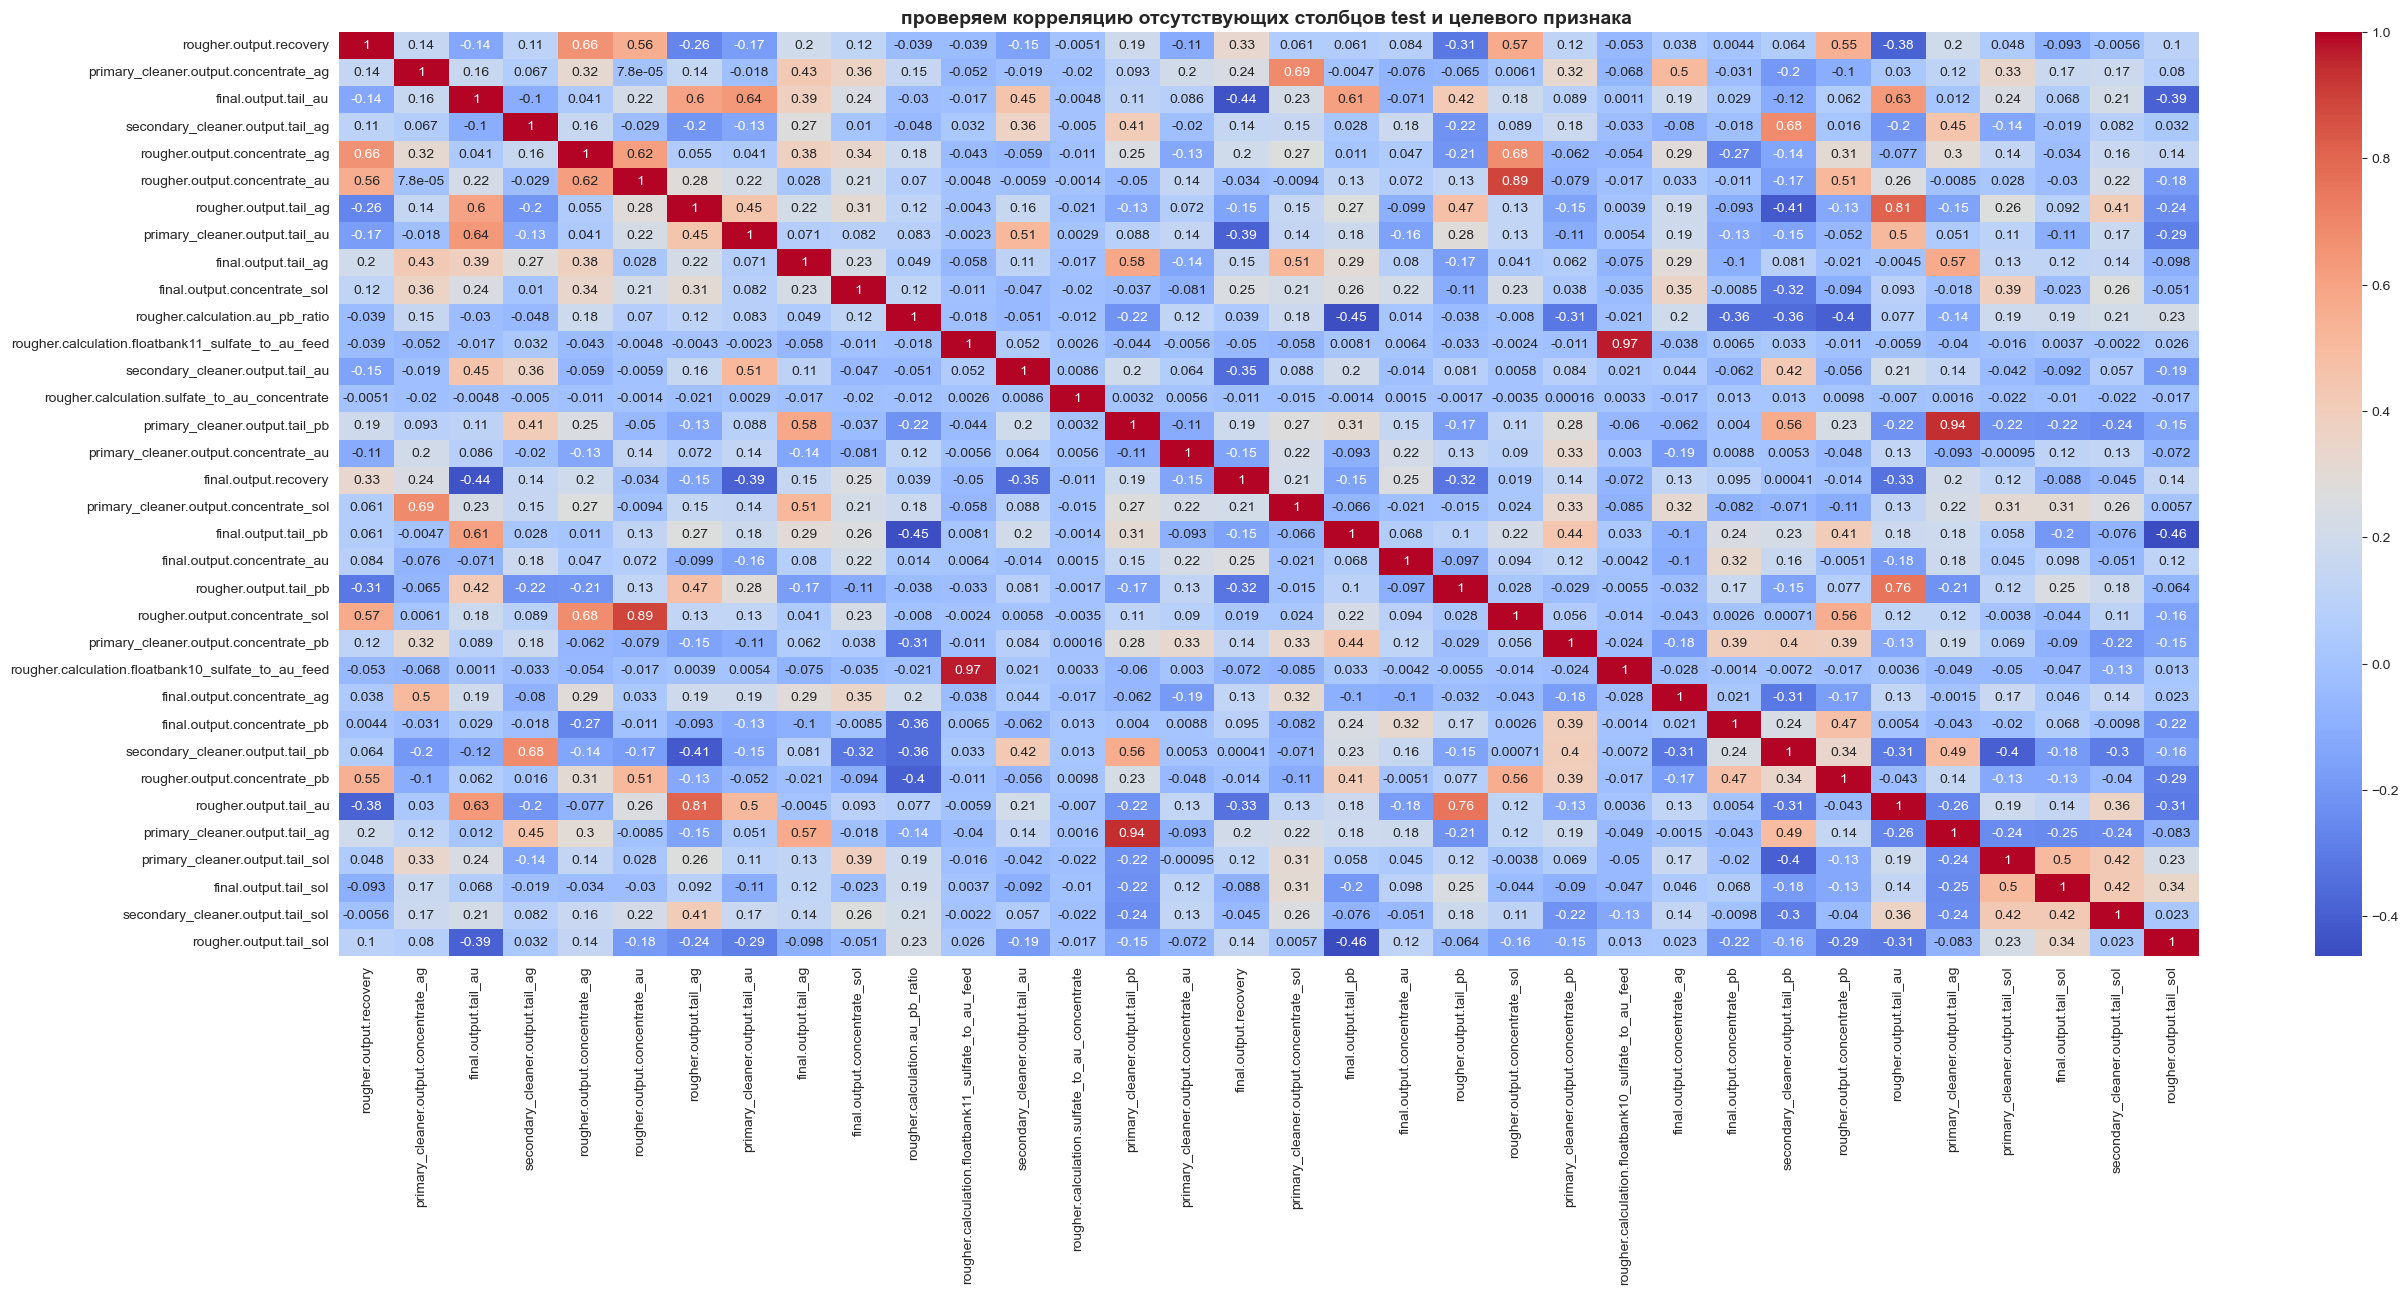

In [463]:
# проверим корреляцию отсутствующих столбцов c  final.output.recovery и rougher.output.recovery
exam_corr = data_train.loc[:][gone_columns].copy()
corr = exam_corr.corr()

plt.figure(figsize=(30, 12))
ax = sns.heatmap(data=corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='coolwarm', annot=True);
ax.set_title('проверяем корреляцию отсутствующих столбцов test и целевого признака ',
             dict(fontweight='bold', fontsize=14));
plt.show()

### Вывод
Отсутствующие признаки в test данных это параметры output или calculation<br>
Возможность их интерпритации наступает после флотации и очистки <br>
У целевого признака rougher.output.recovery наблюдается корреляция средней силы с признаками<br>
rougher.output.concentrate_pb, rougher.output.concentrate_au, rougher.output.concentrate_ag,<br>
rougher.output.concentrate_sol<br>
Признак final.output.recovery имеет слабую корреляцию <br>
<br>
Все отсутствующие признаки имеют характеристики целевых признаков и корреляцию средней силы с целевым признаком<br>
Поэтим причинам отсутствующие признаки не подходят для обучения модели<br>

Примем это за факт уберём из train лишние столбцы и будем работать как есть<br>

## Проверим пропуски

In [464]:
# сравним данные в trein и full
data_train.describe(include='all').isin(
    data_full.loc[data_train.index].describe(include='all')).value_counts().to_frame()

0
final.output.concentrate_ag final.output.concentrate_pb final.output.concentrate_sol final.output.concentrate_au final.output.recovery final.output.tail_ag final.output.tail_pb final.output.tail_sol final.output.tail_au primary_cleaner.input.sulfate primary_cleaner.input.depressant primary_cleaner.input.feed_size primary_cleaner.input.xanthate primary_cleaner.output.concentrate_ag primary_cleaner.output.concentrate_pb primary_cleaner.output.concentrate_sol primary_cleaner.output.concentrate_au primary_cleaner.output.tail_ag primary_cleaner.output.tail_pb primary_cleaner.output.tail_sol primary_cleaner.output.tail_au primary_cleaner.state.floatbank8_a_air primary_cleaner.state.floatbank8_a_level primary_cleaner.state.floatbank8_b_air primary_cleaner.state.floatbank8_b_level primary_cleaner.state.floatbank8_c_air primary_cleaner.state.floatbank8_c_level primary_cleaner.state.floatbank8_d_air primary_cleaner.state.floatbank8_d_level rougher.calculation.sulfate_to_au_concentrate rougher.calculation.floatbank10_sulfate_to_au_feed rougher.calculation.floatbank11_sulfate_to_au_feed rougher.calculation.au_pb_ratio rougher.input.feed_ag rougher.input.feed_pb rougher.input.feed_rate rougher.input.feed_size rougher.input.feed_sol rougher.input.feed_au rougher.input.floatbank10_sulfate rougher.input.floatbank10_xanthate rougher.input.floatbank11_sulfate rougher.input.floatbank11_xanthate rougher.output.concentrate_ag rougher.output.concentrate_pb rougher.output.concentrate_sol rougher.output.concentrate_au rougher.output.recovery rougher.output.tail_ag rougher.output.tail_pb rougher.output.tail_sol rougher.output.tail_au rougher.state.floatbank10_a_air rougher.state.floatbank10_a_level rougher.state.floatbank10_b_air rougher.state.floatbank10_b_level rougher.state.floatbank10_c_air rougher.state.floatbank10_c_level rougher.state.floatbank10_d_air rougher.state.floatbank10_d_level rougher.state.floatbank10_e_air rougher.state.floatbank10_e_level rougher.state.floatbank10_f_air rougher.state.floatbank10_f_level secondary_cleaner.output.tail_ag secondary_cleaner.output.tail_pb secondary_cleaner.output.tail_sol secondary_cleaner.output.tail_au secondary_cleaner.state.floatbank2_a_air secondary_cleaner.state.floatbank2_a_level secondary_cleaner.state.floatbank2_b_air secondary_cleaner.state.floatbank2_b_level secondary_cleaner.state.floatbank3_a_air secondary_cleaner.state.floatbank3_a_level secondary_cleaner.state.floatbank3_b_air secondary_cleaner.state.floatbank3_b_level secondary_cleaner.state.floatbank4_a_air secondary_cleaner.state.floatbank4_a_level secondary_cleaner.state.floatbank4_b_air secondary_cleaner.state.floatbank4_b_level secondary_cleaner.state.floatbank5_a_air secondary_cleaner.state.floatbank5_a_level secondary_cleaner.state.floatbank5_b_air secondary_cleaner.state.floatbank5_b_level secondary_cleaner.state.floatbank6_a_air secondary_cleaner.state.floatbank6_a_level   
True                        True                        True                         True                        True                  True                 True                 True                  True                 True                          True                             True                            True                           True                                  True                                  True                                   True                                  True                           True                           True                            True                           True                                   True                                     True                                   True                                     True                                   True                                     True                                   True                                     True                                          True                                               True                            

In [465]:
# посмотрим на признаки с различиями
exam1 = data_full.loc[data_train.index]['primary_cleaner.state.floatbank8_a_air'].describe() == data_train[
    'primary_cleaner.state.floatbank8_a_air'].describe()
exam2 = data_full.loc[data_train.index]['secondary_cleaner.state.floatbank2_b_air'].describe() == data_train[
    'secondary_cleaner.state.floatbank2_b_air'].describe()
exam3 = data_full.loc[data_train.index]['secondary_cleaner.state.floatbank2_b_level'].describe() == data_train[
    'secondary_cleaner.state.floatbank2_b_level'].describe()
exam4 = data_full.loc[data_train.index]['secondary_cleaner.state.floatbank5_a_air'].describe() == data_train[
    'secondary_cleaner.state.floatbank5_a_air'].describe()
exam_equal = pd.concat([exam1, exam2, exam3, exam4], axis=1)
display(exam_equal)

,primary_cleaner.state.floatbank8_a_air,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank5_a_air
count,True,True,True,True
mean,True,True,True,True
std,False,True,True,True
min,True,True,True,True
25%,True,True,True,False
50%,True,True,True,True
75%,True,False,True,True
max,True,True,False,True


In [466]:
# сравним суммы столбцов с различиями в описании
exam1 = data_full.loc[data_train.index]['primary_cleaner.state.floatbank8_a_air'].sum() == data_train[
    'primary_cleaner.state.floatbank8_a_air'].sum()
exam2 = data_full.loc[data_train.index]['secondary_cleaner.state.floatbank2_b_air'].sum() == data_train[
    'secondary_cleaner.state.floatbank2_b_air'].sum()
exam3 = data_full.loc[data_train.index]['secondary_cleaner.state.floatbank2_b_level'].sum() == data_train[
    'secondary_cleaner.state.floatbank2_b_level'].sum()
exam4 = data_full.loc[data_train.index]['secondary_cleaner.state.floatbank5_a_air'].sum() == data_train[
    'secondary_cleaner.state.floatbank5_a_air'].sum()

if exam1 == exam2 == exam3 == exam4:
    print(f'Суммы в столбцах в которых наблюдались различия равны.')

Суммы в столбцах в которых наблюдались различия равны.


Видим, что данные в train и full полностью совпадают<br>
Различия в столбцах
primary_cleaner.state.floatbank8_a_air
secondary_cleaner.state.floatbank2_b_air
secondary_cleaner.state.floatbank2_b_level
secondary_cleaner.state.floatbank5_a_air
Не значительные, можем предположить, что получились в результате округления<br>


In [467]:
# сравним данные в test и full
data_test.describe(include='all').isin(data_full.loc[data_test.index].describe(include='all')).value_counts().to_frame()

,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0
primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,
True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,8


Данные data_full и data_test равны
Убедились, что данные train и test принадлежат data_frame full

In [468]:
# разложим названия признаком по группам
split = pd.DataFrame([*data_full.columns.str.split(".")], columns=['stage', 'parameter_type', 'parameter_name'])

# посмотрим сколько всего уникальных этапов, состояний и параметров
stage = pd.Series(split['stage'])
parameter_type = pd.Series(split['parameter_type'])
parameter_name = pd.Series(split['parameter_name'])  #.unique()
parameter_columns_name = pd.concat([stage, parameter_type, parameter_name], axis=1)
# parameter_columns_name

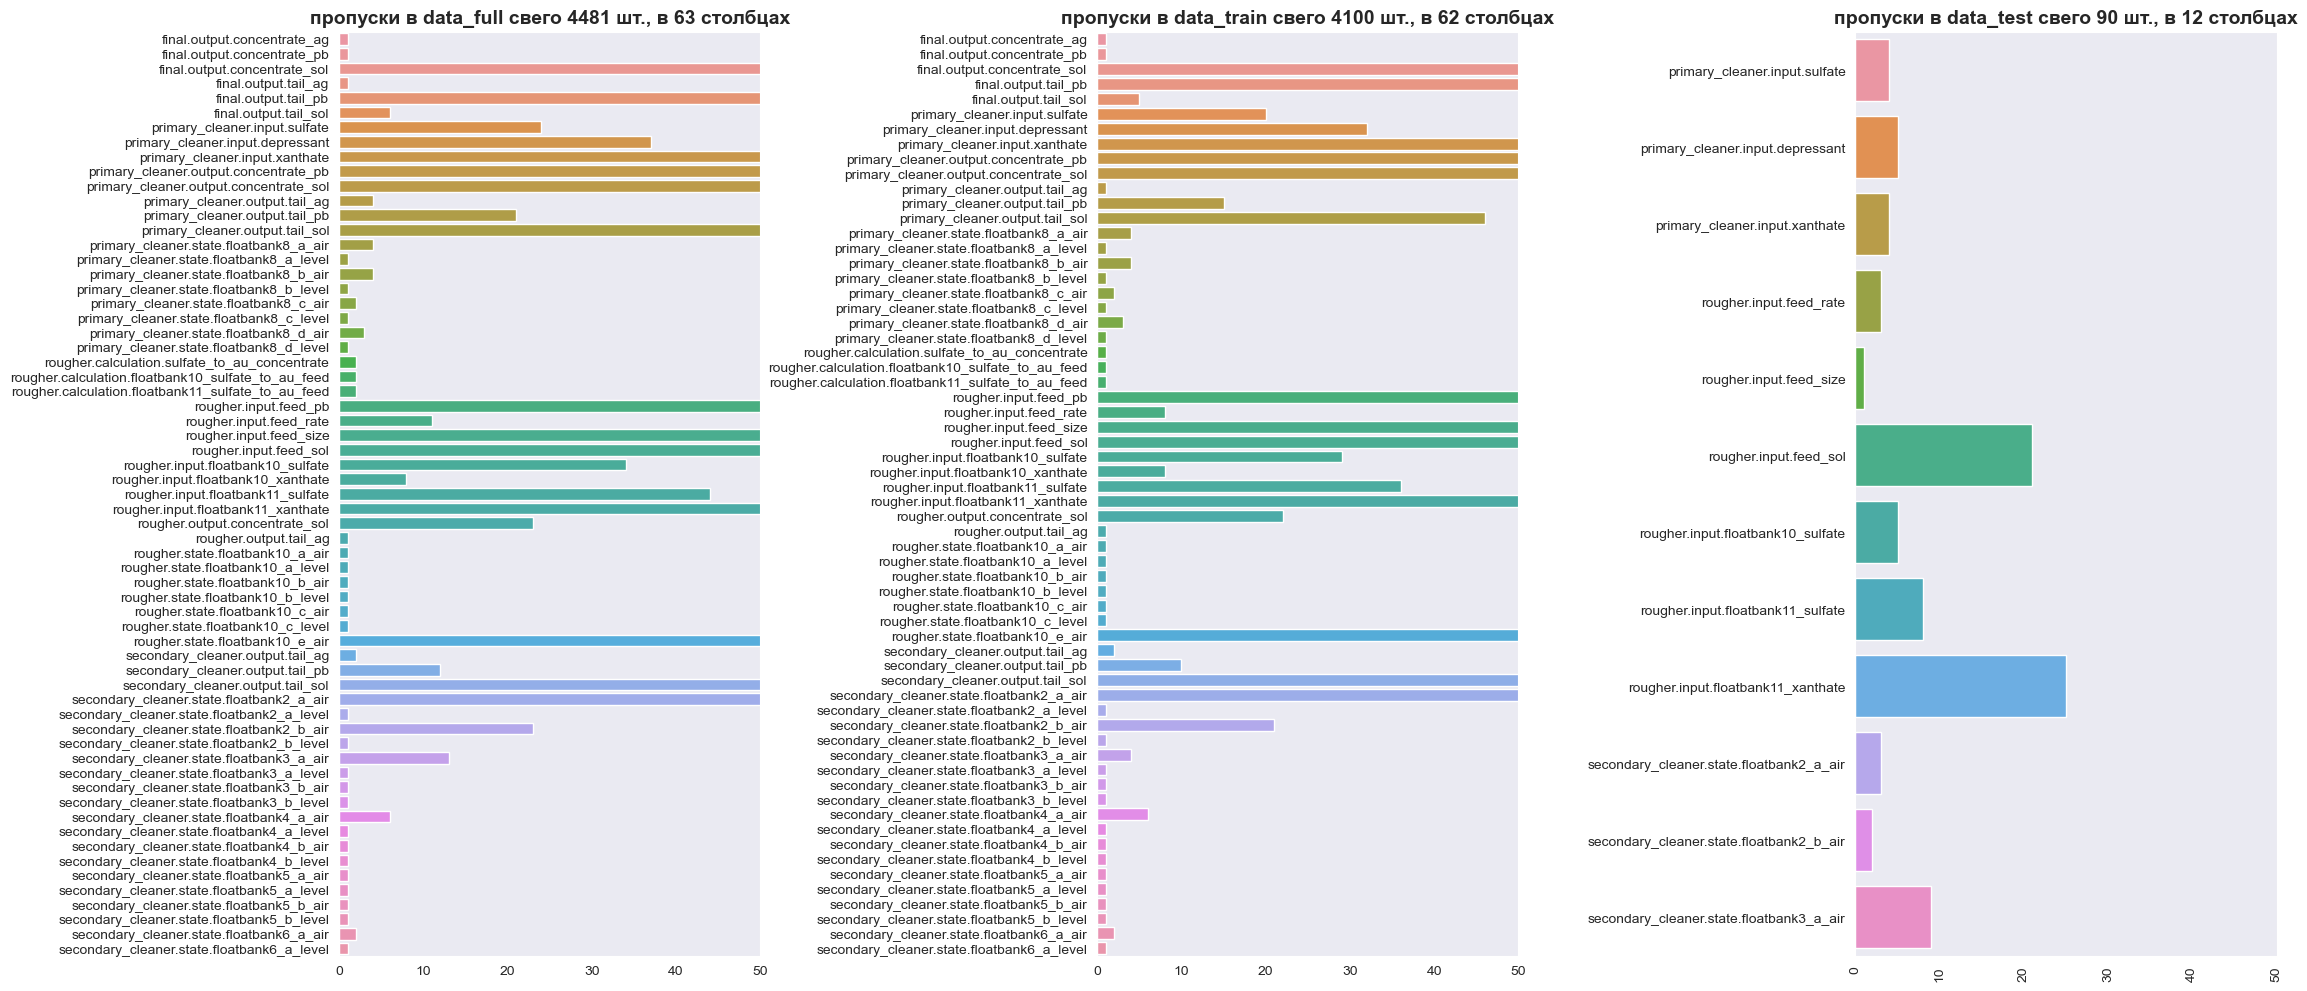

In [469]:
# проверим пропуски и создадим графическое изображение для сравнения
exam_full = data_full.isna().sum() > 0
exam_full = pd.DataFrame(data_full.isna().sum()[exam_full]).T

exam_train = data_train.isna().sum() > 0
exam_train = pd.DataFrame(data_train.isna().sum()[exam_train]).T

exam_test = data_test.isna().sum() > 0
exam_test = pd.DataFrame(data_test.isna().sum()[exam_test]).T

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 12));
plt.subplots_adjust(wspace=0.8, hspace=0.5)
full = (sns.barplot(data=exam_full, orient='h', ax=ax1).set_title(
    'пропуски в data_full свего {} шт., в {} столбцах'.format(exam_full.values.sum(), len(exam_full.T)),
    dict(fontweight='bold', fontsize=14)));
axes = full.axes.set(xlim=(0, 50));

train = (sns.barplot(data=exam_train, orient='h', ax=ax2).set_title(
    'пропуски в data_train свего {} шт., в {} столбцах'.format(exam_train.values.sum(), len(exam_train.T)),
    dict(fontweight='bold', fontsize=14)));
axes = train.axes.set(xlim=(0, 50));

test = (sns.barplot(data=exam_test, orient='h', ax=ax3).set_title(
    'пропуски в data_test свего {} шт., в {} столбцах'.format(exam_test.values.sum(), len(exam_test.T)),
    dict(fontweight='bold', fontsize=14)));
axes = test.axes.set(xlim=(0, 50));

plt.xticks(rotation=90);

Посмотрели на пропуски, везде есть <br>
В описании сказано, что значения признаков расположенных рядом близки <br>
Заполним пропуски в data_full значениями расположенными рядом <br>
Затем поделим на train и test выборку соблюдая пропорции которые есть <br>
И наминал столбцов test выборки

In [470]:
# проверим наличие пропусков в последней строке
isna_last_row = data_full[data_full.columns][-1:].values
if np.isnan(isna_last_row[0]).sum() > 0:
    print('В последней строчке есть пропуски и надо их заполнить в первую очередь')
else:
    print('В последней строчке нет пропусков, можно реализовывать заполнение подстановкой близко стоящим значением')


В последней строчке нет пропусков, можно реализовывать заполнение подстановкой близко стоящим значением


In [471]:
%%time
isna_data_full = data_full.copy()
isna_data_full = isna_data_full.fillna(method='bfill', axis=0)

CPU times: user 14.8 ms, sys: 17.3 ms, total: 32.2 ms
Wall time: 179 ms


In [472]:
# проверим заполнение
display(isna_data_full.describe())

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,19439.000000,19439.000000,19439.000000,19439.000000,19439.000000,19439.000000,19439.000000,19439.000000,19439.000000,19439.000000,...,19439.000000,19439.000000,19439.000000,19439.000000,19439.000000,19439.000000,19439.000000,19439.000000,19439.000000,19439.000000
mean,5.168382,9.978817,9.441265,44.076513,67.050208,9.688356,2.694390,10.582984,3.042467,144.502167,...,18.985683,-485.897735,15.010210,-461.083174,15.694166,-488.684070,12.198006,-487.150492,18.958457,-505.441087
std,1.372368,1.669232,2.849194,5.129784,10.125840,2.328808,0.959863,2.868807,0.922808,44.624552,...,5.411424,47.759450,4.890150,67.406760,5.510977,34.532507,5.332973,38.346438,5.550513,37.693984
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.798523,0.000000,-800.836914,-0.372054,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,4.251000,9.137225,7.674529,43.402215,63.299712,8.062715,2.027553,8.938662,2.461138,113.990977,...,14.975304,-500.705070,11.940333,-500.187767,10.988528,-500.458409,8.971074,-500.129455,14.983005,-500.728189
50%,5.066039,10.102264,9.193185,45.011244,68.172738,9.743106,2.743965,10.622340,2.984909,143.154076,...,18.017317,-499.837795,14.970988,-499.459790,14.999920,-499.802570,11.019389,-499.935338,19.960511,-500.048424
75%,5.895401,11.035644,10.925465,46.275313,72.686642,11.134242,3.329206,12.103709,3.571351,175.014449,...,23.012460,-498.249814,19.034114,-400.118175,18.026184,-498.383889,14.019040,-499.437546,24.002617,-499.495403
max,16.001945,17.031899,19.615720,52.756638,100.000000,19.552149,5.804178,22.317730,8.245022,265.983123,...,30.115735,-245.239184,31.269706,-6.506986,43.709931,-244.483566,27.926001,-137.740004,32.188906,-104.427459


### Вывод
Пропуски присутствуют во всех дата фреймах, их природа не ясна<br>
Подтвердили, что data_train  и data_test являются выборками из data_full <br>
Поскольку значения расположенные рядом часто похожи, по условию<br>
Заменили пропуски в data_full близ лежащими значениями<br>
Пропуски в остальных дата фреймах обрабатывать не стали<br>
Потому, что мы их создадим заново из data_full

## Воссоздание train и test выборки

Исходя из того, что train и test выборки это поделённый data_full <br>
Воссоздадим наборы train и test заново из подготовленного isna_data_full<br>
Соблюдая пропорции и наминал признаков test выборки<br>

In [473]:
# определим размер тестовой выборки
size_test_data = len(data_test)/len(data_full)
print(f'Размер тестовой выбореи равен {size_test_data:.2%}')

Размер тестовой выбореи равен 27.21%


In [474]:
# создадим датафрейт с признаками test выборки + целевые признаки
new_data_full = isna_data_full[TEST_COLUMNS].copy()
# напилим выборок для работы
features = new_data_full.drop(columns=TARGET, axis=1).copy()
target = new_data_full[TARGET].copy()
X_feat, X_valid, y_feat, y_valid = (train_test_split(features, target, test_size=.2721, random_state=RANDOM_STATE))

In [475]:
scaler = StandardScaler().fit(X_feat)

X_feat_ss = pd.DataFrame(scaler.transform(X_feat), index=X_feat.index, columns=features.columns)
X_valid_ss = pd.DataFrame(scaler.transform(X_valid), index=X_valid.index, columns=features.columns)

## Анализ данных

### Изменение концентрации металов (Au, Ag, Pb) на разных стадиях очистки

In [476]:
# функция принимает название металла выбирает подходящие признаки и выводит гфик концентрации металлов
def metal_concentration_graphs(metal, concentrate_colum=CONCENTRATE_METRICS):
    column = ['{}_{}'.format(x, metal) for x in CONCENTRATE_METRICS]
    mean_concentr = pd.DataFrame(data=isna_data_full[column].median(), columns=[metal])
    mean_concentr.index = CONCENTRATE_METRICS

    fig, (ax, ax1) = plt.subplots(1, 2, figsize=(25, 5))
    fig.subplots_adjust(wspace=.4)
    sns.kdeplot(data=isna_data_full[column], fill=True, common_norm=False, palette=color_pal[:4],
                alpha=.7, linewidth=2, ax=ax)
    # sns.lineplot(data=mean_concentr, linewidth=4, legend=False, ax=ax1)
    sns.boxplot(data=isna_data_full[column], ax=ax1, orient='h')

    ax.set_xlabel('concentrate', dict(fontstyle='oblique', fontweight='medium', fontsize=20, ))
    ax1.set_xlabel('concentrate', dict(fontstyle='oblique', fontweight='medium', fontsize=20, ))
    ax.set_title('концентрация {} на разных этапах очистки'.format(metal.upper()),
                 dict(fontstyle='oblique', fontweight='bold', fontsize=20));
    ax1.set_title('концентрация {} на разных этапах очистки'.format(metal.upper()),
                  dict(fontstyle='oblique', fontweight='bold', fontsize=20));
    ax.xaxis.grid(True)
    ax1.xaxis.grid(True)
    return mean_concentr


plt.show();

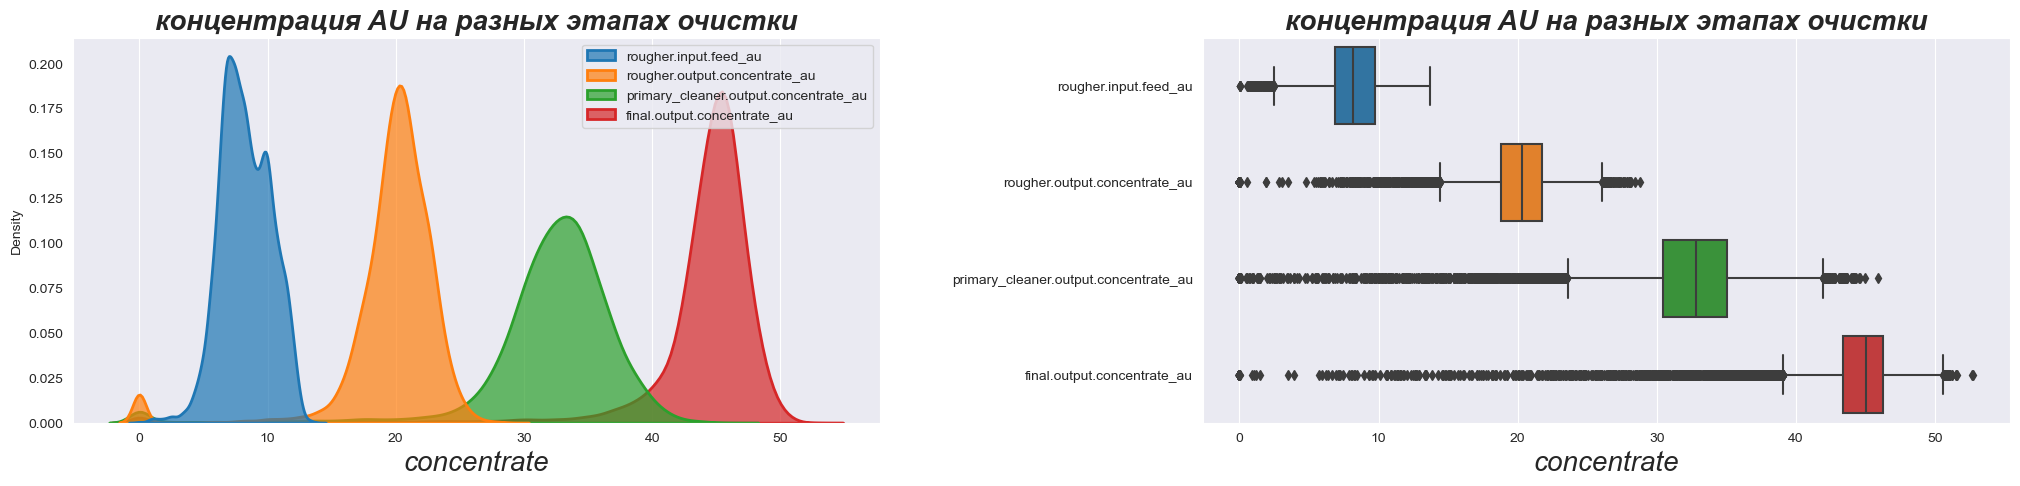

In [477]:
au_mean_concentr = metal_concentration_graphs('au');

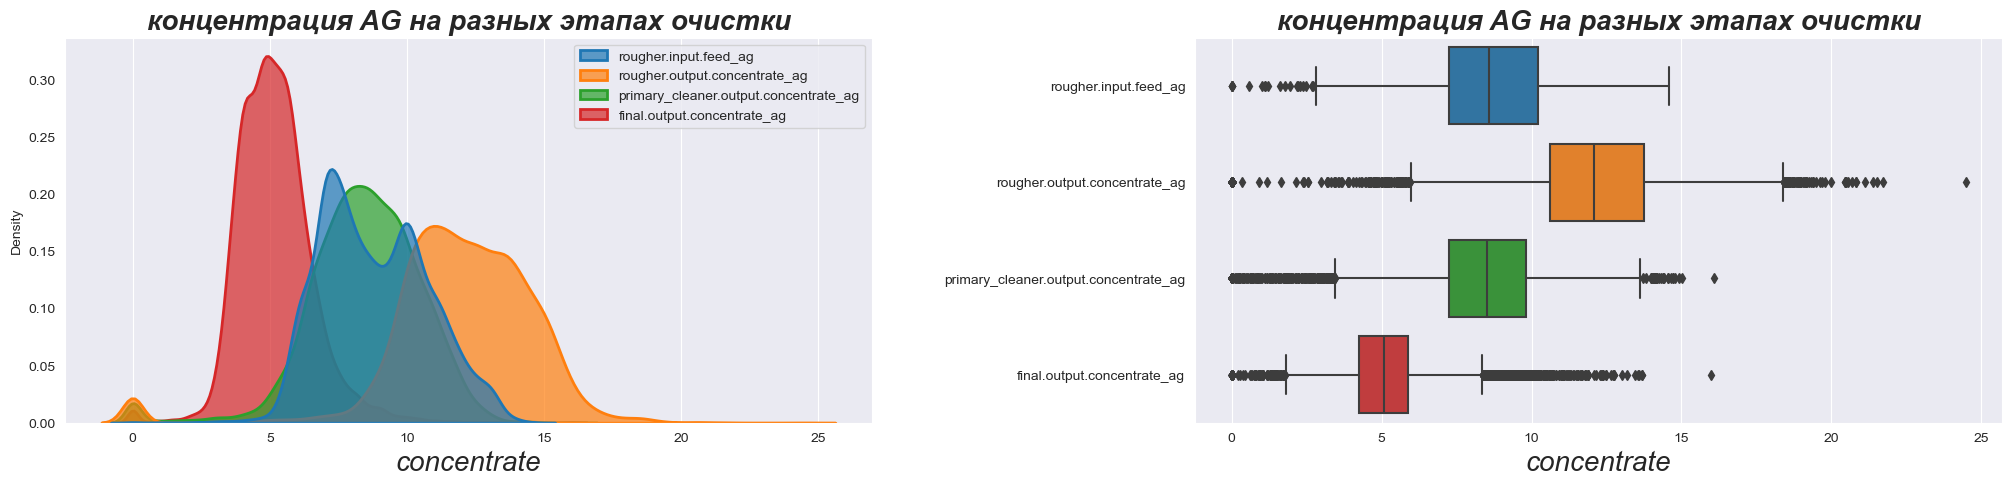

In [478]:
ag_mean_concentr = metal_concentration_graphs('ag')

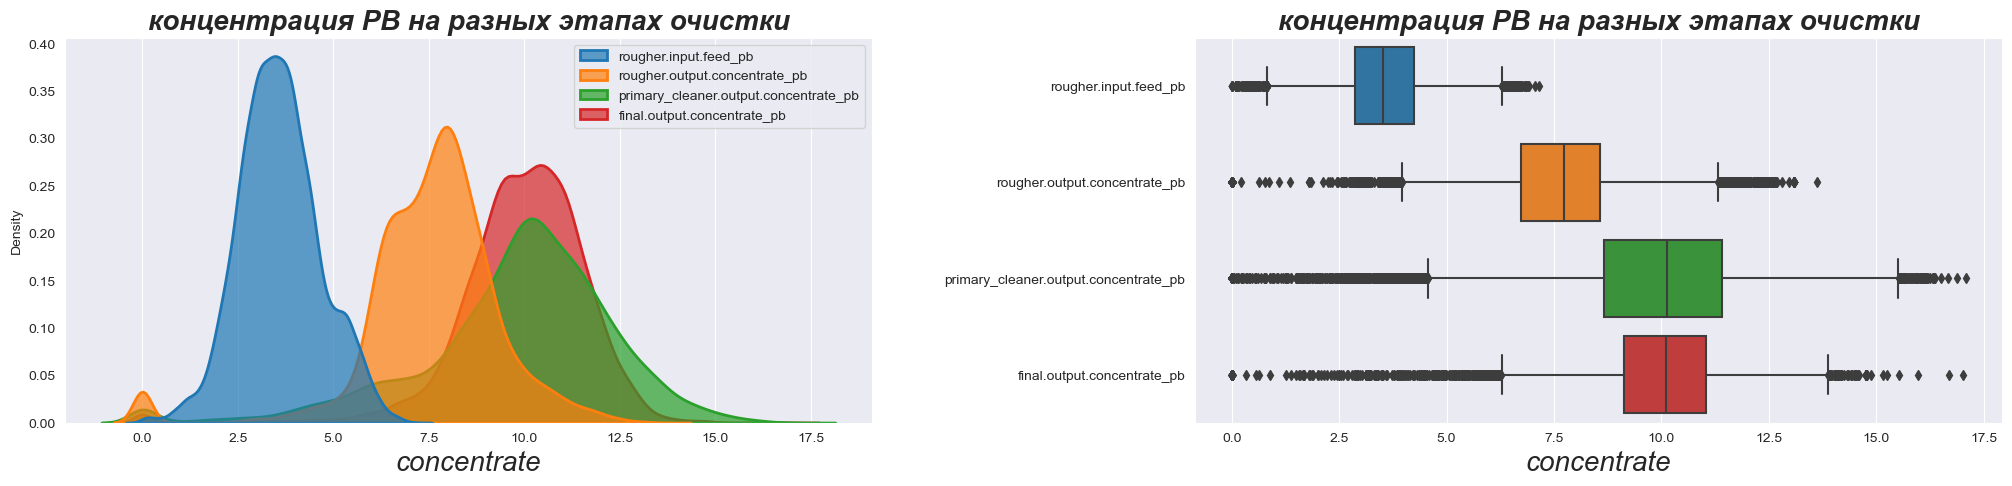

In [479]:
pb_mean_concentr = metal_concentration_graphs('pb')

In [480]:
mean_concentr_list = pd.concat([au_mean_concentr, ag_mean_concentr, pb_mean_concentr], axis=1).T
mean_concentr_list

,rougher.input.feed,rougher.output.concentrate,primary_cleaner.output.concentrate,final.output.concentrate
au,8.125839,20.280214,32.841295,45.011244
ag,8.593574,12.098115,8.507298,5.066039
pb,3.528235,7.742580,10.140400,10.102264


#### Вывод

В процессе очистки концентрация золото (AU) увеличивается в 5.5 раза относительно первоначальной<br>
Концентрация серебра (AG) уменьшилась на 41% относительно первоначальной<br>
Концентрация свинца (PB) увеличивается в 2.8 раза относительно первоначальной<br>

Можно заметить на графиках "концентрации металлов на этапах очистки", что есть небольшое количество значений около нуля<br>
Предполагаем, что это нормально, поскольку не во всей поступающей руде есть металлы и у нас есть небольшое количество<br>
Руды концентрация металлов в которой равно нули или близко к нулю<br>

### Распределение размеров гранул сырья на обучающей и тестовой выборках

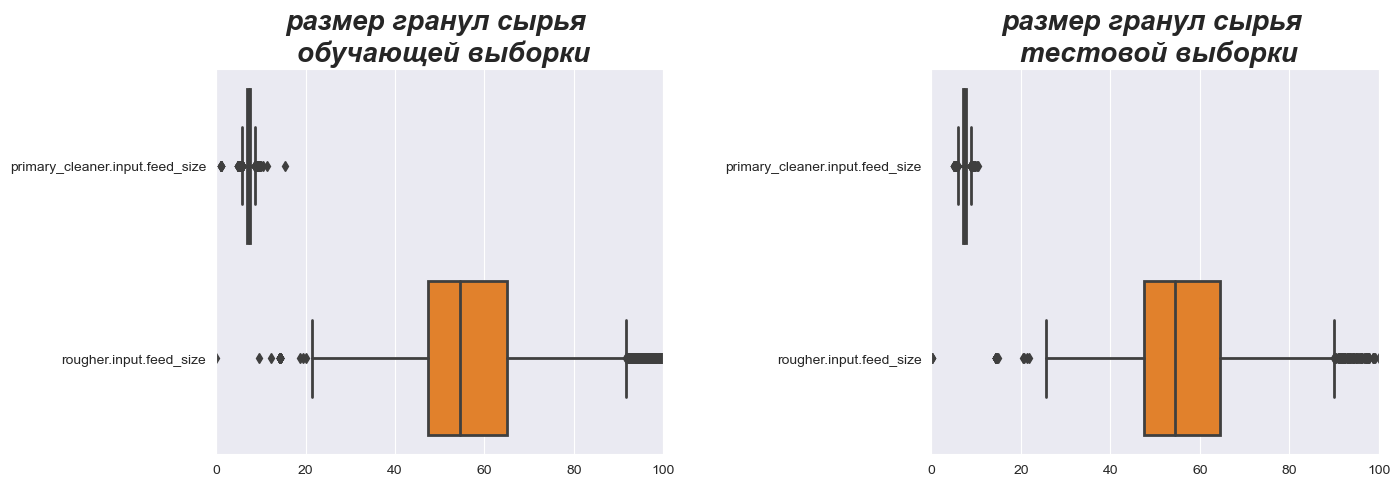

In [481]:
# сгенерируем список с признаков с размерами гранул сырья
feed_size_list = [x for x in X_feat if 'feed_size' in x]

# создадим боксплот для описания размеров гранул сырья
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(15, 5))
fig.subplots_adjust(wspace=.6)

ax.set_xlim([0, 100])
ax1.set_xlim([0, 100])
sns.set_style("dark")
sns.boxplot(data=X_feat[feed_size_list], orient='h', palette=color_pal[:4], linewidth=2, ax=ax) \
    .set_title('размер гранул сырья \n обучающей выборки', dict(fontstyle='oblique', fontweight='bold', fontsize=20));
sns.boxplot(data=X_valid[feed_size_list], orient='h', palette=color_pal[:4], linewidth=2, ax=ax1) \
    .set_title('размер гранул сырья \n тестовой выборки', dict(fontstyle='oblique', fontweight='bold', fontsize=20));

ax.xaxis.grid(True)
ax1.xaxis.grid(True)

#### Вывод

Видим, что размер гранул сырья до флотации и до очистки одинаковые у тренировочной и тестовой выборки<br>
Логично, что на вход флотации поступает парода с размером гранул в широком диапазоне<br>
От 25 до 90, после флотации порода измельчается и на следующих этапах очистки размер гранул находится<br>
В меньшем диапазоне приблизительно от 5 до 15<br>
Есть маленькое количество гранул до флотации с размером около нуля, что в принципе невозможно<br>
Поэтому проверим и если есть нулевой размер гранул удалим его<br>

In [482]:
if (X_feat['rougher.input.feed_size'] <= 0).any():
    print('В обучающей выборке есть руда с размером гранул ноль или отрицательным размером')
elif (X_valid['rougher.input.feed_size'] <= 0).any():
    print('В тестовой выборке есть руда с размером гранул ноль или отрицательным размером')
else:
    print('В выборках нет руды с размером ноль или отрицательным размером гранул породы')


В выборках нет руды с размером ноль или отрицательным размером гранул породы


### Суммарная концентрация всех веществ

рассмотрим концентрацию всех веществ на этапах очистки

In [483]:
# функция считает количество всех элементов на разных этапах очистки и возвращает новый датафрейм
def all_elements(data, metal, name, concentrate):
    data_hole = pd.DataFrame(None)
    for index, value in enumerate(concentrate):
        data_hole[name[index]] = pd.DataFrame(data['{}{}'.format(value, metal[0])] \
                                              + data['{}{}'.format(value, metal[1])] \
                                              + data['{}{}'.format(value, metal[2])] \
                                              + data['{}{}'.format(value, metal[3])], \
                                              columns=[name[index]])
    return data_hole.copy()

In [484]:
# посмотрим как концентрация всех элементов менялась по ходу очистки на графике
def all_alements(data, name):
    fig, (ax, ax1) = plt.subplots(1, 2, figsize=(25, 5))

    sns.kdeplot(data=data, fill=True, palette=color_pal[:4], ax=ax);
    sns.move_legend(ax, "upper left")
    sns.boxplot(data=data, ax=ax1)
    ax.set_title('концентрация элементов \nв {} на разных этапах очистки'.format(name), \
                 dict(fontstyle='oblique', fontweight='bold', fontsize=20));
    ax1.set_title('концентрация элементов \nв {} на разных этапах очистки'.format(name), \
                  dict(fontstyle='oblique', fontweight='bold', fontsize=20));



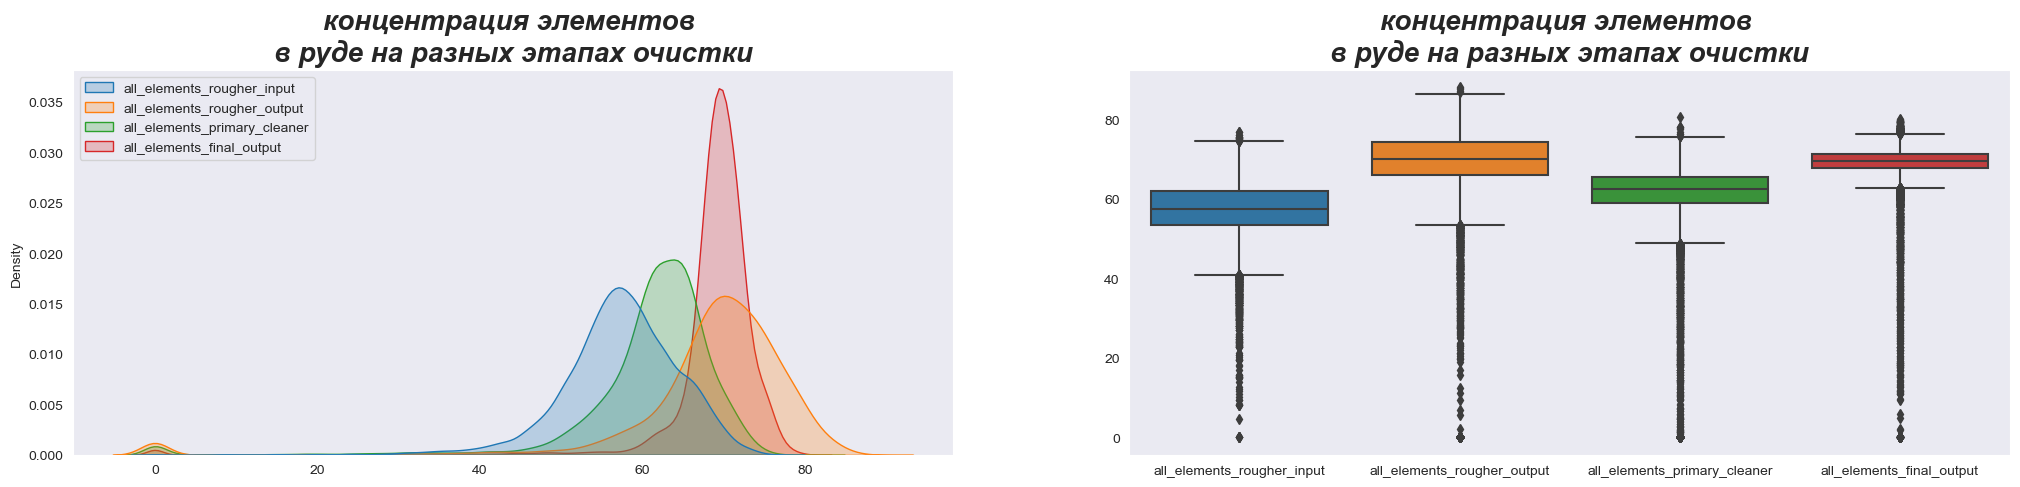

In [485]:
# объявим список с названиями элементов и список с названиями новых признаков
metal = ['_au', '_ag', '_pb', '_sol']
name = ['all_elements_rougher_input', \
    'all_elements_rougher_output', \
    'all_elements_primary_cleaner', \
    'all_elements_final_output']

data_hole = all_elements(data=isna_data_full, metal=metal, name=name, concentrate=CONCENTRATE_METRICS)
all_ruda = all_alements(data=data_hole, name='руде')

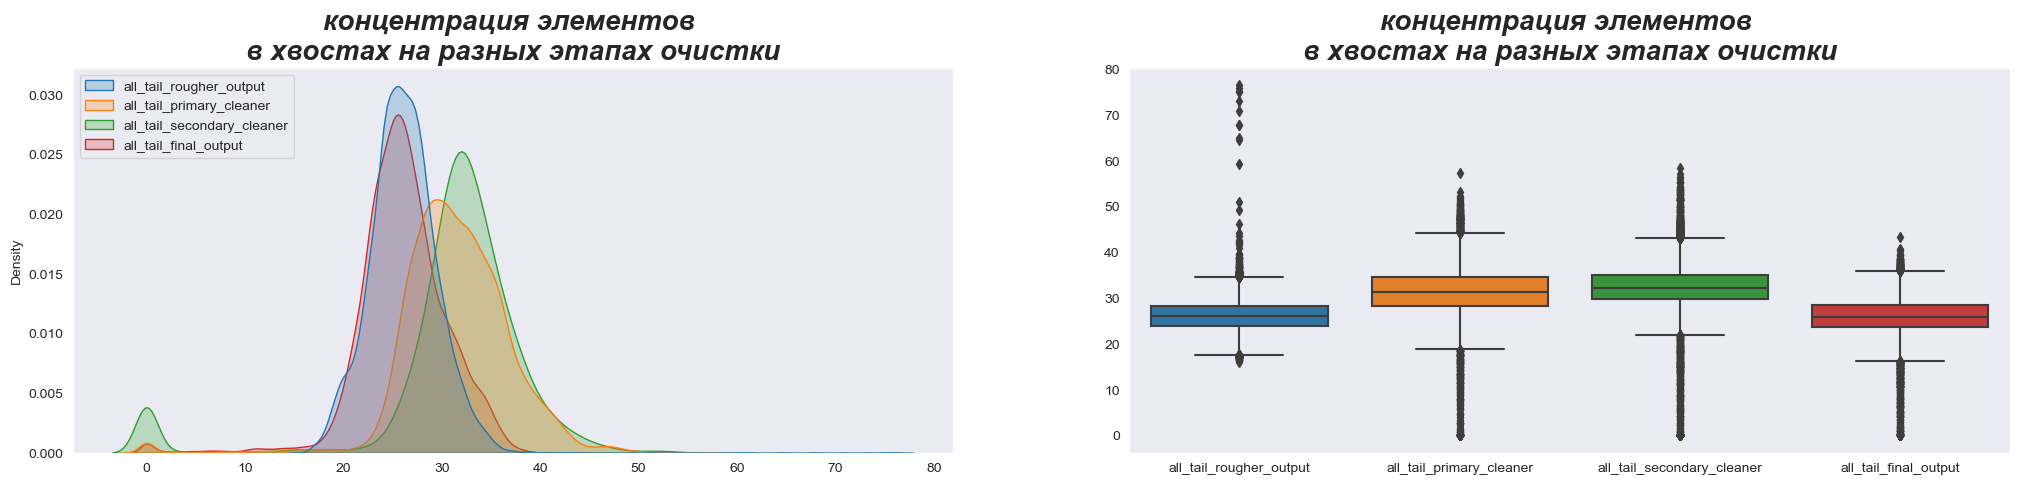

In [486]:
# объявим список с названиями элементов и список с названиями новых признаков
metal_tail = ['tail_au', 'tail_ag', 'tail_pb', 'tail_sol']
name_tail = ['all_tail_rougher_output', \
    'all_tail_primary_cleaner', \
    'all_tail_secondary_cleaner', \
    'all_tail_final_output']

data_hole_tail = all_elements(data=isna_data_full, metal=metal_tail, name=name_tail, concentrate=TAIL_METRICS)
all_tail = all_alements(data=data_hole_tail, name='хвостах')

#### Вывод
Можно отметить, что концентрация всех металлов к финалу очистки стала плотнее<br>
В начальной руде диапазон концентрации элементов находился от 40 до 75 <br>
После финальной очистки диапазон ужался и находится приблизительно от 62 до 78<br>
Это произошло вследствие того, что во время очистки пустая руда отфильтровалась<br>
<br>
Концентрация элементов в хвостах на этапах очистки, практически, не изменялась


## Модель

напишем фенкцию для расчета финального SMAPE
<br>
<img src='https://pictures.s3.yandex.net/resources/_smape_1576239054.jpg' width="600" height="150">

In [487]:
# считаем sMape
def smape(past_recovery, model_recovery):
    sMape = 100/len(past_recovery) \
            *np.sum(2*np.abs(model_recovery - past_recovery)/(np.abs(past_recovery) + np.abs(model_recovery)))
    return sMape

# sMape для модели с мультитаргетом
def final_smape_multi(roughert, final):
    rougher_output_recovery = roughert['rougher.output.recovery']
    final_output_recovery = roughert['final.output.recovery']

    sMape_rougher = smape(past_recovery=rougher_output_recovery, model_recovery=final[:, 0])
    sMape_final = smape(past_recovery=final_output_recovery, model_recovery=final[:, 1])
    s_final_mape = (.25*sMape_rougher) + (.75*sMape_final)

    return s_final_mape

# sMape для модели с одним таргетом
def final_smape_simple(roughert, final):
    sMape_simple = smape(past_recovery=roughert, model_recovery=final)
    s_final_mape = sMape_simple

    return s_final_mape

In [524]:
table_sMape = pd.DataFrame({'LinearRegression':None, 'RandomForestRegressor':None, 'DecisionTreeRegressor':None}, \
                           index=['multi_target', 'rougher.output.recovery', 'final.output.recovery', \
                                                                's_final_mape']).reset_index()


### LinearRegression

In [489]:
%%time
# линейная регресия с мульти таргетом
smape_scorer = make_scorer(final_smape_multi)

model_lr = LinearRegression()
lr_multi_target = cross_val_score(model_lr, X_feat_ss, y_feat, \
                                  cv=5, scoring=smape_scorer, n_jobs=-1).mean()

print('Финальный sMAPE для линейной регрессии и мультитаргете: {:.3f}'.format(lr_multi_target))

Финальный sMAPE для линейной регрессии и мультитаргете: 9.261
CPU times: user 39.4 ms, sys: 92.4 ms, total: 132 ms
Wall time: 4.36 s


In [490]:
%%time
# линейная регресия с одним таргетом
smape_sco = make_scorer(final_smape_simple)
ror_simple_target_lr = cross_val_score(model_lr, X_feat_ss, y_feat['rougher.output.recovery'],\
                                       cv=5, scoring=smape_sco,  n_jobs=-1).mean()


# линейная регресия с одним таргетом
for_simple_target_lr = cross_val_score(model_lr, X_feat_ss, y_feat['final.output.recovery'],\
                                       cv=5, scoring=smape_sco,  n_jobs=-1).mean()

s_final_mape_lr = (.25*ror_simple_target_lr) + (.75*for_simple_target_lr)

print('sMAPE для линейной регрессии для rougher.output.recovery: {:.3f}'.format(ror_simple_target_lr))
print('sMAPE для линейной регрессии для final.output.recovery: {:.3f}'.format(for_simple_target_lr))
print('Финальный sMAPE линейной регрессии для однотаргетовых моделей: {:.3f}'.format(s_final_mape_lr))

sMAPE для линейной регрессии для rougher.output.recovery: 9.725
sMAPE для линейной регрессии для final.output.recovery: 9.107
Финальный sMAPE линейной регрессии для однотаргетовых моделей: 9.261
CPU times: user 38.9 ms, sys: 27.5 ms, total: 66.4 ms
Wall time: 1.24 s


In [529]:
# заполняем таблицу значениями скоринга
table_sMape.at[0, 'LinearRegression'] = lr_multi_target
table_sMape.at[1, 'LinearRegression'] = ror_simple_target_lr
table_sMape.at[2, 'LinearRegression'] = for_simple_target_lr
table_sMape.at[3, 'LinearRegression'] = s_final_mape_lr

#### Результат
В момент написания финальная  sMape у LinearRegression с двойным таргетом идентична финальной ошибки для <br>
моделей с одним таргетом <br>


### RandomForestRegressor

In [492]:
%%time
# GridSearchCV RandomForestRegressor с мульти тагретом
parameters = {'n_estimators': range(60, 82, 3), 'max_depth': range(2, 20, 3), }
model_rfr = RandomForestRegressor(random_state=RANDOM_STATE)
metrics = make_scorer(final_smape_multi, greater_is_better=False)

search_rfr = GridSearchCV(model_rfr, parameters, cv=5, scoring=metrics, n_jobs=-1)
search_rfr = search_rfr.fit(X_feat_ss, y_feat)
print('Финальное sMAPE для случайного леса: {:.3f} при значениях гиперпараметров: {}' \
      .format(np.abs(search_rfr.best_score_), search_rfr.best_params_))


Финальное sMAPE для случайного леса: 7.386 при значениях гиперпараметров: {'max_depth': 17, 'n_estimators': 78}
CPU times: user 46.3 s, sys: 627 ms, total: 46.9 s
Wall time: 25min 48s


перебор параметров был шире, в процессе тестирования выбраны лучшие <br>
для экономии времени в примерах ниже диапазон перебора сокращен

In [493]:
%%time
# GridSearchCV RandomForestRegressor для rougher.output.recovery
parameters = {'n_estimators': range(72, 73, 2), 'max_depth': range(29, 30, 2)}
metrics_simple = make_scorer(final_smape_simple, greater_is_better=False)
ror_search_rfr = GridSearchCV(model_rfr, parameters, cv=5, scoring=metrics_simple, n_jobs=-1)

ror_search_rfr = ror_search_rfr.fit(X_feat_ss, y_feat['rougher.output.recovery'])

# GridSearchCV RandomForestRegressor для final.output.recovery
parameters = {'n_estimators': range(72, 73, 2), 'max_depth': range(29, 30, 2)}
fro_search_rfr = GridSearchCV(model_rfr, parameters, cv=5, scoring=metrics_simple, n_jobs=-1)
for_search_rfr = fro_search_rfr.fit(X_feat_ss, y_feat['final.output.recovery'])

s_final_mape_rfr = (.25*np.abs(ror_search_rfr.best_score_)) + (.75*np.abs(for_search_rfr.best_score_))

print('sMAPE для случайного леса rougher.output.recovery: {:.3f} при значениях гиперпараметров: {}' \
      .format(np.abs(ror_search_rfr.best_score_), ror_search_rfr.best_params_))
print('sMAPE для случайного леса final.output.recovery: {:.3f} при значениях гиперпараметров: {}' \
      .format(np.abs(for_search_rfr.best_score_), for_search_rfr.best_params_))
print('Финальный sMAPE линейной регрессии для однотаргетовых моделей: {:.3f}'.format(s_final_mape_rfr))

sMAPE для случайного леса rougher.output.recovery: 7.464 при значениях гиперпараметров: {'max_depth': 29, 'n_estimators': 72}
sMAPE для случайного леса final.output.recovery: 7.067 при значениях гиперпараметров: {'max_depth': 29, 'n_estimators': 72}
Финальный sMAPE линейной регрессии для однотаргетовых моделей: 7.166
CPU times: user 1min 39s, sys: 712 ms, total: 1min 39s
Wall time: 4min 33s


In [530]:
# заполняем таблицу значениями скоринга
table_sMape.at[0, 'RandomForestRegressor'] = np.abs(search_rfr.best_score_)
table_sMape.at[1, 'RandomForestRegressor'] = np.abs(ror_search_rfr.best_score_)
table_sMape.at[2, 'RandomForestRegressor'] = np.abs(for_search_rfr.best_score_)
table_sMape.at[3, 'RandomForestRegressor'] = s_final_mape_rfr

#### Результат
Средняя и финальная шибка sMape у моделей RandomForestRegressor с одинарным таргетом меньше чем модели с двойным таргетом

### DecisionTreeRegressor

In [495]:
%%time
# GridSearchCV DecisionTreeRegressor для мульти таргета
parameters = {'max_depth': range(2, 56, 2)}
model_dtr = DecisionTreeRegressor(random_state=RANDOM_STATE)
metrics_multi = make_scorer(final_smape_multi, greater_is_better=False)

search_dtr = GridSearchCV(model_dtr, parameters, cv=5, scoring=metrics_multi, n_jobs=-1)
search_dtr = search_dtr.fit(X_feat_ss, y_feat)
print('Финальное sMAPE для случайного леса: {:.3f} при значениях гиперпараметров: {}' \
                        .format(np.abs(search_dtr.best_score_), search_dtr.best_params_))


Финальное sMAPE для случайного леса: 8.560 при значениях гиперпараметров: {'max_depth': 10}
CPU times: user 958 ms, sys: 86.8 ms, total: 1.04 s
Wall time: 36.9 s


In [496]:
%%time
# GridSearchCV DecisionTreeRegressor для rougher.output.recovery
parameters = {'max_depth': range(2, 56, 2)}
metrics_simple = make_scorer(final_smape_simple, greater_is_better=False)
ror_search_dtr = GridSearchCV(model_dtr, parameters, cv=5, scoring=metrics_simple, n_jobs=-1)

ror_search_dtr = ror_search_dtr.fit(X_feat_ss, y_feat['rougher.output.recovery'])

# GridSearchCV DecisionTreeRegressor для final.output.recovery
for_search_dtr = GridSearchCV(model_dtr, parameters, cv=5, scoring=metrics_simple, n_jobs=-1)
for_search_dtr = for_search_dtr.fit(X_feat_ss, y_feat['final.output.recovery'])

s_final_mape_dtr = (.25*np.abs(ror_search_dtr.best_score_)) + (.75*np.abs(for_search_dtr.best_score_))

print('sMAPE дерева решений rougher.output.recovery: {:.3f} при значениях гиперпараметров: {}' \
      .format(np.abs(ror_search_dtr.best_score_), ror_search_dtr.best_params_))
print('sMAPE дерева решений final.output.recovery: {:.3f} при значениях гиперпараметров: {}' \
      .format(np.abs(for_search_dtr.best_score_), for_search_dtr.best_params_))
print('Финальный sMAPE дерева решений для однотаргетовых моделей: {:.3f}'.format(s_final_mape_dtr))

sMAPE дерева решений rougher.output.recovery: 6.934 при значениях гиперпараметров: {'max_depth': 22}
sMAPE дерева решений final.output.recovery: 8.936 при значениях гиперпараметров: {'max_depth': 8}
Финальный sMAPE дерева решений для однотаргетовых моделей: 8.435
CPU times: user 2.23 s, sys: 121 ms, total: 2.35 s
Wall time: 1min 7s



#### Результат
Модель DecisionTreeRegressor с мульти таргетом показала почти такой же результат<br>
Как и финальная величина скоринга моделей с одним таргетом <br>
Модель для rougher.output.recovery показала лучший sMape среди остальных

In [531]:
# заполняем таблицу значениями скоринга
table_sMape.at[0, 'DecisionTreeRegressor'] = np.abs(search_dtr.best_score_)
table_sMape.at[1, 'DecisionTreeRegressor'] = np.abs(ror_search_dtr.best_score_)
table_sMape.at[2, 'DecisionTreeRegressor'] = np.abs(for_search_dtr.best_score_)
table_sMape.at[3, 'DecisionTreeRegressor'] = s_final_mape_dtr



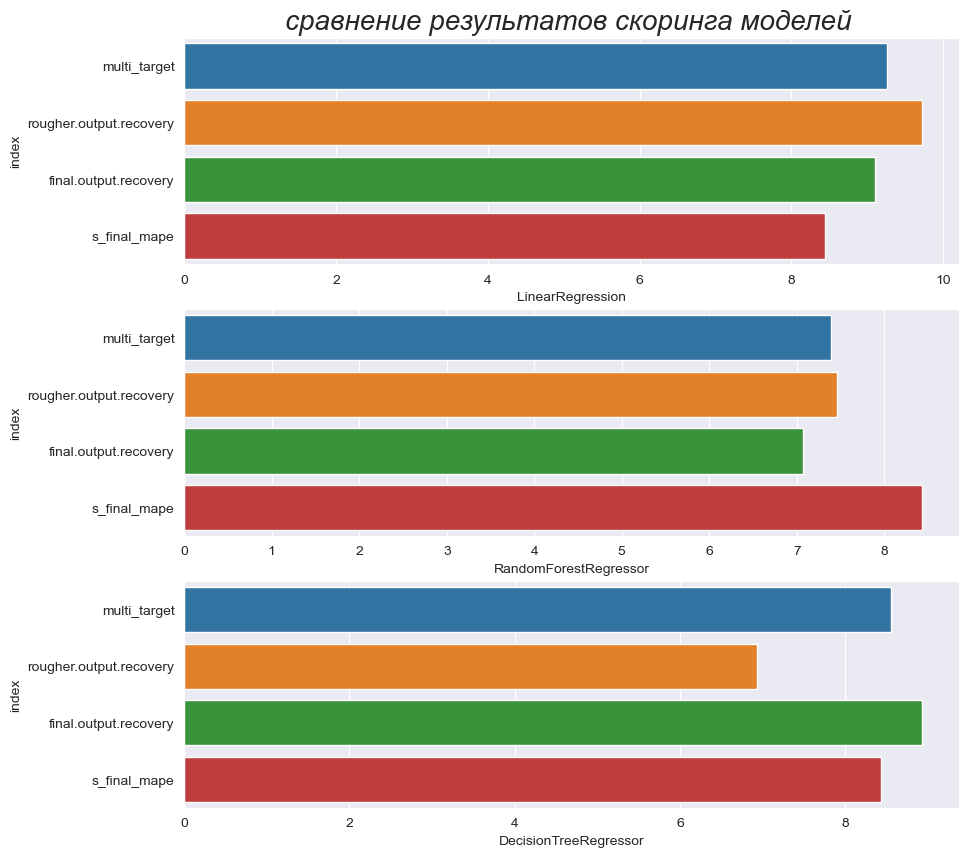

,index,LinearRegression,RandomForestRegressor,DecisionTreeRegressor
0,multi_target,9.261219,7.386496,8.560393
1,rougher.output.recovery,9.724514,7.46374,6.934412
2,final.output.recovery,9.106788,7.067314,8.935727
3,s_final_mape,8.435398,8.435398,8.435398


In [538]:
# визуальное отображение скоринга моделей
fig, (ax, ax1, ax2) = plt.subplots(3,1, figsize=(10,10))
sns.barplot(data=table_sMape, y='index', x='LinearRegression', ax=ax, orient='h');
sns.barplot(data=table_sMape, y='index', x='RandomForestRegressor', ax=ax1, orient='h');
sns.barplot(data=table_sMape, y='index', x='DecisionTreeRegressor', ax=ax2, orient='h');
ax.set_title('сравнение результатов скоринга моделей ', dict(fontstyle='oblique', fontweight='medium', fontsize=20));

ax.xaxis.grid(True)
ax1.xaxis.grid(True)
ax2.xaxis.grid(True)
plt.show()

table_sMape

### Проверка на тестовой выборке

In [539]:
%%time

test_model_dtr = DecisionTreeRegressor(max_depth=22,random_state=RANDOM_STATE)
test_model_dtr.fit(X_feat_ss, y_feat['rougher.output.recovery'])
test_predict_dtr = test_model_dtr.predict(X_valid_ss)


test_model_rfr = RandomForestRegressor(n_estimators=72, max_depth=29, random_state=RANDOM_STATE)
test_model_rfr.fit(X_feat_ss, y_feat['final.output.recovery'])
test_predict_rfr = test_model_rfr.predict(X_valid_ss)


CPU times: user 51.8 s, sys: 643 ms, total: 52.5 s
Wall time: 53.6 s


In [540]:


final_teble_predict = pd.concat([y_valid, pd.DataFrame(test_predict_dtr, columns=['predict_rougher.output.recovery'], \
                     index=y_valid.index),  pd.DataFrame(test_predict_rfr, columns=['predict_final.output.recovery'], \
                     index=y_valid.index)], axis=1)

s_final_mape = (.25*final_smape_simple(final_teble_predict['rougher.output.recovery'],\
                                       final_teble_predict['predict_rougher.output.recovery'] ) +
                (.75*final_smape_simple(final_teble_predict['final.output.recovery'], \
								       final_teble_predict['predict_final.output.recovery'])))
print('Финальная sMape на тестовых данных равна: {:.2f}'.format(s_final_mape))

Финальная sMape на тестовых данных равна: 6.93


In [545]:
table_sMape

,index,LinearRegression,RandomForestRegressor,DecisionTreeRegressor
0,multi_target,9.261219,7.386496,8.560393
1,rougher.output.recovery,9.724514,7.46374,6.934412
2,final.output.recovery,9.106788,7.067314,8.935727
3,s_final_mape,8.435398,8.435398,8.435398


### Вывод
По результатам проведённого исследования и подбора лучшей модели по наименьшей ошибке sMape <br>
Лучший результат показала модель RandomForestRegressor для final.output.recovery 7.067314 <br>
С параметрами 'max_depth': 29, 'n_estimators': 72<br>
И DecisionTreeRegressor для rougher.output.recovery с результатом 6.934412 <br>
С параметрами 'max_depth': 22
<br>
Для проверки на тестовых данных использовали модели с одним таргетом<br>
<br>
Только модель RandomForestRegressor с мульти таргетом показала немного лучший результат<br>
Чем финальное значение sMape моделей с одним таргетов <br>
У моделей LinearRegression и DecisionTreeRegressor результат скоринга моделей с двойным таргетом<br>
Показал хуже результат финальная ошибка моделей с одиночным таргетом<br>

Предполагаем, что при подборе гиперпараметров у моделей с двойным таргетом результат усредняется<br>
Вследствие чего страдает качество<br>
В отличие от однотаргетовых моделей в которых параметры для каждого предсказания подбираются <br>
Индивидуально и результат лучше

Объединив разные модели удалось показать финальную ошибку на тестовых данных <br>
Лучше, чем все ошибки на тренировочных данных

## Чек-лист готовности проекта

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке выполнения
- [x]  Выполнен шаг 1: данные подготовлены
    - [x]  Проверена формула вычисления эффективности обогащения
    - [x]  Проанализированы признаки, недоступные в тестовой выборке
    - [x]  Проведена предобработка данных
- [x]  Выполнен шаг 2: данные проанализированы
    - [x]  Исследовано изменение концентрации элементов на каждом этапе
    - [x]  Проанализированы распределения размеров гранул на обучающей и тестовой выборках
    - [x]  Исследованы суммарные концентрации
- [x]  Выполнен шаг 3: построена модель прогнозирования
    - [x]  Написана функция для вычисления итогового *sMAPE*
    - [x]  Обучено и проверено несколько моделей
    - [x]  Выбрана лучшая модель, её качество проверено на тестовой выборке